In [1]:
import numpy as np
import sklearn as sk
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
current_dir = os.getcwd()

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
housing = fetch_california_housing()
m, n = housing.data.shape

In [4]:
frame = pd.DataFrame(housing.data)
frame.head()

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
frame.shape

(20640, 8)

In [6]:
target = pd.DataFrame(housing.target)
target.shape

(20640, 1)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(frame, target, test_size = 0.20, random_state = 42)

# Ensemble learning


In [8]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor()
gbrt.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
pred = gbrt.predict(x_test)
from sklearn.metrics import mean_squared_error
print('Training score: ', gbrt.score(x_train, y_train))
print('Testing score: ', mean_squared_error(y_test, pred))

Training score:  0.8048978817773167
Testing score:  0.29393470011606526


In [10]:
def compute_accuracy(y_test, pred):
    output = []
    for i, j in zip(y_test, pred):
        cal = i/j
        if cal > 1:
            output.append(np.round(j/i))
            
        else:
            output.append(np.round(cal))
            
    return np.sum(output)/len(output)

print(compute_accuracy(y_test, pred))

0.0


# Manually computing MSE with the use of optimizers

In [84]:
from keras.backend import clear_session
clear_session()

In [85]:
batch_size = 1000
n_batches = int(np.ceil(16512/batch_size))
print('number of batches is: ', str(n_batches))

number of batches is:  17


In [86]:
def fetch_batch(batch_index):
    if batch_index < n_batches-1:
        start = batch_index * batch_size
        stop = batch_size + start
        x_batch = x_train[start:stop]
        y_batch = y_train[start:stop]
        
    else:
        start = batch_index* batch_size
        x_batch = x_train[start:]
        y_batch = y_train[start:]
    return x_batch, y_batch

In [87]:
x_train.shape, y_train.shape

((16512, 8), (16512, 1))

In [88]:
m, n = x_train.shape

In [89]:
#X = tf.constant(housing_data_plus_bias, dtype =tf.float32, name = 'X')
#y = tf.constant(housing.target.reshape(-1,1), dtype = tf.float32, name = 'y')

X = tf.placeholder(tf.float32, shape = (None,8), name = 'x')
y = tf.placeholder(tf.float32, shape = (None,1), name = 'y')

with tf.name_scope('loss'):
    #theta = tf.Variable(tf.random_uniform((8,1), -1.0, 1.0), name = 'theta')
    stddev = 2/np.sqrt(8)
    w = tf.Variable(tf.random_normal((8,1), stddev = stddev, name = 'weights'))
    b = tf.Variable(tf.zeros(m,1), name = 'biases')
    y_pred = tf.add(tf.matmul(X,w),b, name= 'predictions')
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name = 'mse')
    
with tf.name_scope('training'):
    learning_rate = 0.01
    optimizer= tf.train.RMSPropOptimizer(learning_rate = learning_rate)
    training_op = optimizer.minimize(mse)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

train_loss, test_loss = [],[]

n_epochs = 50
with tf.Session() as sess:
    
    init.run()
    for epoch in range(n_epochs):
        batch_step = 0
        avg_loss = 0
        total_loss = 0
        total_batch = int(x_train.shape[0]/batch_size)
        for batch_index in range(n_batches):
            x_batch, y_batch = fetch_batch(batch_index)
            _,l = sess.run([training_op, mse], feed_dict= {X:x_batch, y:y_batch})
            batch_step+=1
            total_loss +=l
        if epoch % 10 == 0: # print 5 batches of epochs
            avg_loss = total_loss/batch_size
            print("Epoch:", '%02d' % (epoch+1), "| Average Training Loss= {:.2f}".format(avg_loss), 
                  "| Training MSE:  {:.2f}".format(mse.eval({X: x_train, y: y_train})),
                  "| Test/Validation MSE:  {:.2f}".format(mse.eval({X: x_test, y: y_test})))
            train_loss.append(mse.eval({X:x_train, y:y_train}))
            test_loss.append(mse.eval({X:x_test, y:y_test}))
        else:
            train_loss.append(mse.eval({X:x_train, y:y_train}))
            test_loss.append(mse.eval({X:x_test, y:y_test}))
    
    print("Model fit complete.")
    print("Final Training MSE: {:.2f}".format(mse.eval({X: x_train, y: y_train})))
    print("Final Validation MSE: {:.2f}".format(mse.eval({X: x_test, y: y_test})))
    save_path = saver.save(sess, './house_reg.ckpt')

Epoch: 01 | Average Training Loss= 5.07 | Training MSE:  61.50 | Test/Validation MSE:  50.13
Epoch: 10 | Average Training Loss= 1.55 | Training MSE:  74.36 | Test/Validation MSE:  73.66
Epoch: 19 | Average Training Loss= 1.78 | Training MSE:  25.60 | Test/Validation MSE:  25.35
Epoch: 28 | Average Training Loss= 1.53 | Training MSE:  51.34 | Test/Validation MSE:  51.16
Epoch: 37 | Average Training Loss= 1.63 | Training MSE:  35.24 | Test/Validation MSE:  34.54
Epoch: 46 | Average Training Loss= 1.70 | Training MSE:  27.54 | Test/Validation MSE:  27.55
Model fit complete.
Final Training MSE: 27.33
Final Validation MSE: 27.31


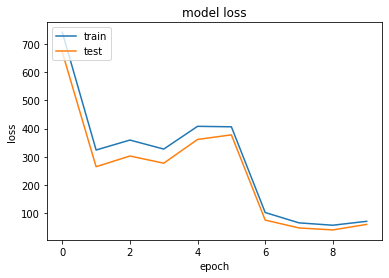

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


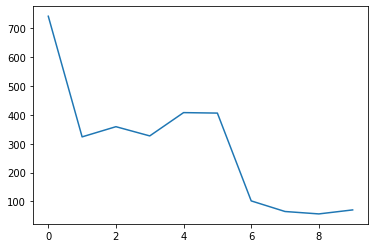

In [18]:
epoch_list = [i for i in range(10)]
import seaborn as sns
ax = sns.lineplot(x=epoch_list, y=train_loss)

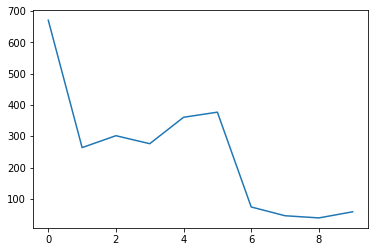

In [19]:
epoch_list = [i for i in range(10)]
import seaborn as sns
ax = sns.lineplot(x=epoch_list, y=test_loss)

# Neural Networks

In [90]:
from keras.backend import clear_session
clear_session()

In [91]:
n_inputs = 8
h1 = 40
h2 = 100
h3 = 20
n_output = 1

X = tf.placeholder(tf.float32, shape = (None,8), name = 'x')
y = tf.placeholder(tf.float32, shape = (None,1), name = 'y')


def neuron_layer(X, n_neurons, name, activation = None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2/ np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev = stddev)
        W = tf.Variable(init, name = 'weights')
        b = tf.Variable(tf.zeros([n_neurons]), name = 'biases')
        z = tf.matmul(X, W) + b
        
        if activation == 'relu':
            return tf.nn.relu(z)
        
        else:
            return z
        
with tf.name_scope('NeuralNet'):
    hidden1 = neuron_layer(X, h1, 'hidden1', activation = 'relu')
    hidden2 = neuron_layer(hidden1, h2, 'hidden2', activation = 'relu')
    hidden3 = neuron_layer(hidden2, h3, 'hidden3', activation = 'relu')
    y_pred = neuron_layer(hidden3, n_output, 'outputs')

    
with tf.name_scope('loss'):
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name = 'mse')
    
  

In [92]:
with tf.name_scope('training'):
    learning_rate = 0.01
    optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate)
    training_op = optimizer.minimize(mse)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

train_loss = []
test_loss = []
n_epochs = 100


with tf.Session() as sess:
    writer = tf.summary.FileWriter('logs', sess.graph)
    init.run()
    for epoch in range(n_epochs):
        batch_step = 0
        avg_loss = 0
        total_loss = 0
        total_batch = int(x_train.shape[0]/batch_size)
        for batch_index in range(n_batches):
            x_batch, y_batch = fetch_batch(batch_index)
            _,l = sess.run([training_op, mse], feed_dict= {X:x_batch, y:y_batch})
            batch_step+=1
            total_loss +=l
        if epoch % 10 == 0: # print 5 batches of epochs
            avg_loss = total_loss/batch_size
            print("Epoch:", '%02d' % (epoch+1), "| Average Training Loss= {:.2f}".format(avg_loss), 
                  "| Training MSE:  {:.2f}".format(mse.eval({X: x_train, y: y_train})),
                  "| Test/Validation MSE:  {:.2f}".format(mse.eval({X: x_test, y: y_test})))
            train_loss.append(mse.eval({X:x_train, y:y_train}))
            test_loss.append(mse.eval({X:x_test, y:y_test}))
        
        else:
            train_loss.append(mse.eval({X:x_train, y:y_train}))
            test_loss.append(mse.eval({X:x_test, y:y_test}))
                
         
    
    print("Model fit complete.")
    print("Final Training MSE: {:.2f}".format(mse.eval({X: x_train, y: y_train})))
    print("Final Validation MSE: {:.2f}".format(mse.eval({X: x_test, y: y_test})))
    save_path = saver.save(sess, './house_reg2.h5')
    writer.close()

Epoch: 01 | Average Training Loss= 14017.66 | Training MSE:  46.49 | Test/Validation MSE:  38.42
Epoch: 11 | Average Training Loss= 0.05 | Training MSE:  2.99 | Test/Validation MSE:  2.92
Epoch: 21 | Average Training Loss= 0.02 | Training MSE:  1.34 | Test/Validation MSE:  1.31
Epoch: 31 | Average Training Loss= 0.02 | Training MSE:  1.34 | Test/Validation MSE:  1.31
Epoch: 41 | Average Training Loss= 0.02 | Training MSE:  1.34 | Test/Validation MSE:  1.31
Epoch: 51 | Average Training Loss= 0.02 | Training MSE:  1.34 | Test/Validation MSE:  1.31
Epoch: 61 | Average Training Loss= 0.02 | Training MSE:  1.34 | Test/Validation MSE:  1.31
Epoch: 71 | Average Training Loss= 0.02 | Training MSE:  1.34 | Test/Validation MSE:  1.31
Epoch: 81 | Average Training Loss= 0.02 | Training MSE:  1.34 | Test/Validation MSE:  1.31
Epoch: 91 | Average Training Loss= 0.02 | Training MSE:  1.34 | Test/Validation MSE:  1.31
Model fit complete.
Final Training MSE: 1.34
Final Validation MSE: 1.31


In [93]:
import datetime, os
import tensorboard
%load_ext tensorboard

#%reload_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir} --host localhost --port 8008

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


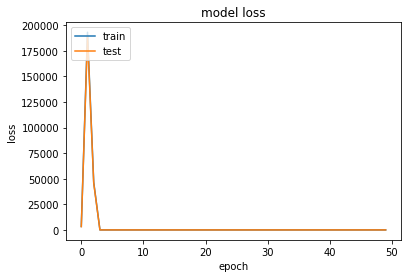

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


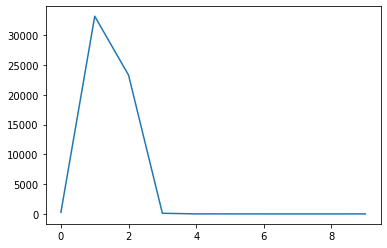

In [34]:
epoch_list = [i for i in range(10)]
import seaborn as sns
ax = sns.lineplot(x=epoch_list, y=train_loss)

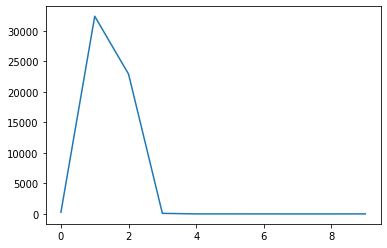

In [35]:
epoch_list = [i for i in range(n_epochs)]
import seaborn as sns
ax = sns.lineplot(x=epoch_list, y=test_loss)

# Keras in tensorflow

In [112]:
import keras 
from tensorflow.compat.v1.keras.backend import clear_session
# Before instantiating a tf.data.Dataset obj & before model creation, call:
clear_session()

In [113]:
from tensorflow.keras import layers
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = tf.keras.Sequential()
model.add(layers.Dense(40,input_shape=(8,), activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1))


In [114]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
              loss= tf.keras.losses.mean_squared_error,
              metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
_________________________________________________________________


In [115]:
h = model.fit(x_train, y_train, epochs=50, batch_size=1000,validation_data=(x_test, y_test),callbacks=[tensorboard_callback])

Train on 16512 samples, validate on 4128 samples
Epoch 1/50
16512/16512 [==============================] - 0s 12us/sample - loss: 29505.2751 - mse: 29505.2773 - val_loss: 3.3144 - val_mse: 3.3144
Epoch 2/50
16512/16512 [==============================] - 0s 5us/sample - loss: 404.9254 - mse: 404.9254 - val_loss: 10.9627 - val_mse: 10.9627
Epoch 3/50
16512/16512 [==============================] - 0s 5us/sample - loss: 564.9246 - mse: 564.9246 - val_loss: 3.0174 - val_mse: 3.0174
Epoch 4/50
16512/16512 [==============================] - 0s 5us/sample - loss: 18.9541 - mse: 18.9541 - val_loss: 21.1946 - val_mse: 21.1946
Epoch 5/50
16512/16512 [==============================] - 0s 5us/sample - loss: 43.4433 - mse: 43.4433 - val_loss: 88.8712 - val_mse: 88.8712
Epoch 6/50
16512/16512 [==============================] - 0s 5us/sample - loss: 6.6784 - mse: 6.6784 - val_loss: 3.7804 - val_mse: 3.7804
Epoch 7/50
16512/16512 [==============================] - 0s 5us/sample - loss: 11.8922 - mse: 1

In [44]:
%tensorboard --logdir logs/scalars

In [116]:
model.evaluate(x_train, y_train)

16512/16512 [==============================] - 0s 22us/sample - loss: 1.3357 - mse: 1.3357


[1.3356765112442563, 1.3356764]

In [117]:
model.evaluate(x_test, y_test)

4128/4128 [==============================] - 0s 19us/sample - loss: 1.3113 - mse: 1.3113


[1.311339514662129, 1.3113396]